# NI-MVI Project – ArXiv Recommender
## Setup
### Library installation

In [1]:
!pip install sentence_transformers
!pip install umap_learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=2c8f9dd270356069514c1019dce8cc1ef27a9fb4e163f247e3ab1a5b613245d8
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


### Imports & aux methods 

In [2]:
import warnings
warnings.filterwarnings('ignore')

import random
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# SentenceTransformers
from sentence_transformers import SentenceTransformer
from sentence_transformers import InputExample
from sentence_transformers import losses
from sentence_transformers.evaluation import TripletEvaluator
from sentence_transformers import util # Similarity search

# PyTorch
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Dimensionality reduction
import umap 

# Clustering
# import hdbscan
from sklearn.cluster import KMeans

# Define device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def truncate_categories(data):
    broad_categories = []
    for category in data['categories']:
        first_category = category.split(' ')[0]  # If multiple categories, take first
        broad_category = first_category.split('.')[0]  # Throw away subcategories
        broad_categories.append(broad_category)

    data['category'] = broad_categories

    data['category'] = np.where(data['category'].str.startswith("hep"), "hep", data['category'])
    data['category'] = np.where(data['category'].str.startswith("nucl"), "nucl", data['category'])


def get_category_distr(data):
    return [len(data[data['category'] == c]) / len(data) for c in data['category'].unique()]


def generate_input_examples(data, n):
    examples = []
    
    # Get the 'probability of each category'
    category_unique = data['category'].unique()
    category_distr = get_category_distr(data)
    
    for i in range(n):
        # Select a random category
        anchor_category = random.choices(category_unique, category_distr)[0]

        # Create temporary dataframes to sample from
        df_positive = data[data['category'] == anchor_category]
        df_negative = data[data['category'] != anchor_category]
        
        # Sample anchor
        random_index = random.randint(0, len(df_positive) - 1)
        anchor_text = df_positive.iloc[random_index]['abstract']

        # Sample positive
        random_index = random.randint(0, len(df_positive) - 1)
        positive_text = df_positive.iloc[random_index]['abstract']

        # Sample negative
        random_index = random.randint(0, len(df_negative) - 1)
        negative_text = df_negative.iloc[random_index]['abstract']

        examples.append(InputExample(texts=[anchor_text, positive_text, negative_text]))
    
    return examples
    

## Load data

In [4]:
# Load json file as a pandas DataFrame
data = pd.read_json('/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json', lines=True, nrows=15000)

print("Dataset shape:", data.shape)
print("Columns:\n", list(data.columns))

Dataset shape: (15000, 14)
Columns:
 ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed']


In [5]:
# Modify categories to be more broad
truncate_categories(data)

# Apply light preprocessing to the abstracts
data['abstract'] = data['abstract'].apply(lambda x: re.sub(r'\s', ' ', x).strip())

# We do not do further preprocessing, because the models were
# trained on data that was not preprocessed.
# https://github.com/UKPLab/sentence-transformers/issues/851

# We do not do tokenization, since the library does it for us

# Keep only the columns we are going to use & reorder
data = data[["category", "title", "abstract"]]

display(data.head())
print(data.shape)

category                                              title  \
0      hep  Calculation of prompt diphoton production cros...   
1     math           Sparsity-certifying Graph Decompositions   
2  physics  The evolution of the Earth-Moon system based o...   
3     math  A determinant of Stirling cycle numbers counts...   
4     math  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   

                                            abstract  
0  A fully differential calculation in perturbati...  
1  We describe a new algorithm, the $(k,\ell)$-pe...  
2  The evolution of Earth-Moon system is describe...  
3  We show that a determinant of Stirling cycle n...  
4  In this paper we show how to compute the $\Lam...

(15000, 3)


In [6]:
train_data, test_data = train_test_split(data, test_size=0.33)

## Fine-tuning

In [7]:
# Load Pre-trained model
model = SentenceTransformer('allenai-specter')

# Move model to gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device);

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/462k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [8]:
# Generate triplets 
train_examples = generate_input_examples(train_data, n=len(train_data))

# Make a dataloader 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=6) # 8 to prevent CUDA OUT OF MEMORY

# Define loss
train_loss = losses.TripletLoss(model=model)

epochs = 2

In [9]:
# Fine tune
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=epochs)
tuned_model = model

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1675 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1675 [00:00<?, ?it/s]

## Measure embedding performance

In [10]:
# Load models
model_pretty_names = [
    'GloVe (avg. word)',
    'BERT',
    'SciBERT',
    'SPECTER',
]
model_names = [
    'average_word_embeddings_glove.6B.300d',
    'bert-base-uncased',
    'allenai/scibert_scivocab_uncased',
    'allenai-specter',
]
models = [SentenceTransformer(name) for name in model_names]

model_pretty_names.append('SPECTER (fine-tuned)')
model_names.append('tuned-model')
models.append(tuned_model)

# Generate test triplets 
test_examples = generate_input_examples(test_data, n=len(test_data))

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)beddings/whitespacetokenizer_config.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

(…)WordEmbeddings/wordembedding_config.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/248 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/491 [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

(…)kage/Data/com.apple.CoreML/model.mlmodel:   0%|          | 0.00/165k [00:00<?, ?B/s]

weight.bin:   0%|          | 0.00/532M [00:00<?, ?B/s]

(…)sk/float32_model.mlpackage/Manifest.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/532M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/437 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

### Triplet loss

In [11]:
def get_triplet_embeddings(examples, model):
    texts = np.array([e.texts for e in examples])
    anchor_examples = texts[:, 0].tolist()
    pos_examples = texts[:, 1].tolist()
    neg_examples = texts[:, 2].tolist()
    
    anchor_embeddings = torch.Tensor(model.encode(anchor_examples, show_progress_bar=True))
    pos_embeddings = torch.Tensor(model.encode(pos_examples, show_progress_bar=True))
    neg_embeddings = torch.Tensor(model.encode(neg_examples, show_progress_bar=True))
    
    return anchor_embeddings, pos_embeddings, neg_embeddings

In [12]:
margin = 1.0

# Define PyTorch cosine triplet loss
cosine_distance = lambda x, y: 1.0 - F.cosine_similarity(x, y)
cosine_triplet_loss = (nn.TripletMarginWithDistanceLoss(distance_function=cosine_distance, margin=margin))

# Define PyTorch euclidean triplet loss
euclidean_triplet_loss = nn.TripletMarginLoss(margin=margin, p=2)

In [13]:
# Calculate losses
cosine_losses = []
euclidean_losses = []
for model in models:
    model.to(device)
    a, p, n = get_triplet_embeddings(test_examples, model)
    
    cosine_losses.append(cosine_triplet_loss(a, p, n))
    euclidean_losses.append(euclidean_triplet_loss(a, p, n))

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

In [14]:
print("Cosine triplet loss:")
for name, loss in zip(model_names, cosine_losses):
    print(f"  {name:40}  {loss:.4f}")
    
print("\nEuclidean triplet loss:")
for name, loss in zip(model_names, euclidean_losses):
    print(f"  {name:40}  {loss:.4f}")
    

Cosine triplet loss:
  average_word_embeddings_glove.6B.300d     0.9475
  bert-base-uncased                         0.9460
  allenai/scibert_scivocab_uncased          0.9557
  allenai-specter                           0.9045
  tuned-model                               0.4345

Euclidean triplet loss:
  average_word_embeddings_glove.6B.300d     0.8302
  bert-base-uncased                         0.5954
  allenai/scibert_scivocab_uncased          0.5626
  allenai-specter                           0.5453
  tuned-model                               0.3266


### Top-k

In [15]:
def top_k_score(data, query_embedding, corpus_embeddings, k):
    search_hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=k)
    search_hits = search_hits[0]
    
    categories = []
    for hit in search_hits:
        related_paper = data.iloc[hit['corpus_id']]
        categories += [related_paper['category']]
    
    original_category = data.iloc[search_hits[0]['corpus_id']]['category']
    
    return categories.count(original_category) / len(categories)


In [16]:
k_range = [5, 10, 15, 25, 50, 100, 250]
n_samples = len(test_data)

scores = []
for model in models:
    model.to(device);
    
    # Get test dataset embeddings
    embeddings = model.encode(list(test_data['abstract']), show_progress_bar=True)
    
    curr_model_scores = []
    for k in k_range:
        curr_k_scores = []
        for i in range(n_samples):
            sample_paper = test_data.iloc[i]
            sample_embedding = embeddings[i]
            curr_k_scores += [top_k_score(test_data, sample_embedding, embeddings, k=k)]

        curr_model_scores += [curr_k_scores]
    
    scores += [curr_model_scores]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

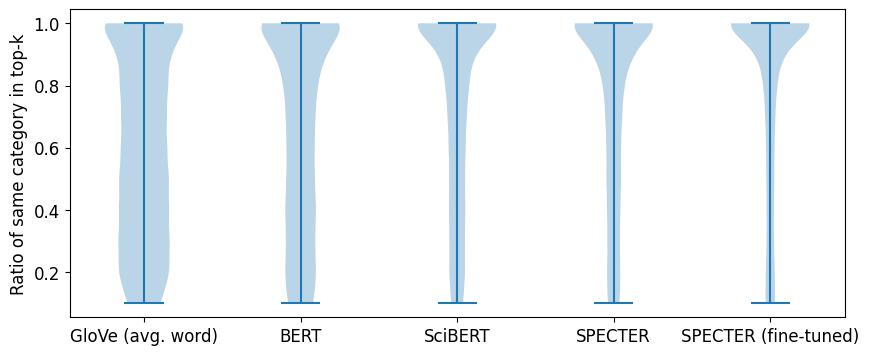

In [17]:
k10_model_scores = [x[1] for x in scores]

plt.figure(figsize=(10, 4));
plt.ylabel("Ratio of same category in top-k", fontsize=12);
plt.violinplot(k10_model_scores);
plt.xticks(list(range(1, len(models) + 1)), model_pretty_names, fontsize=12);
plt.yticks(fontsize=12);

plt.savefig('topk-violin.png')

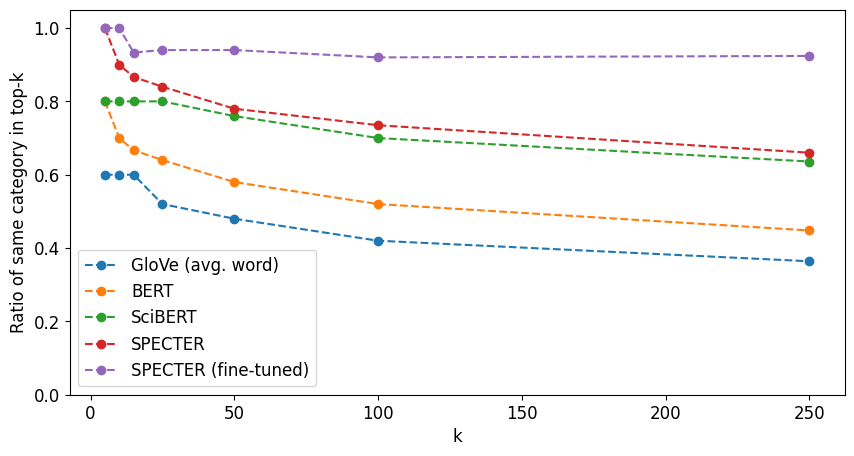

In [18]:
model_mean_scores = []
for model_scores in scores:
    mean_scores = [np.median(np.array(x)) for x in model_scores]
    model_mean_scores += [mean_scores]

plt.figure(figsize=(10, 5))
for s in model_mean_scores:
    plt.plot(k_range, s, '--o');
    plt.xlabel("k", fontsize=12);
    plt.ylabel("Ratio of same category in top-k", fontsize=12);
    plt.xticks(fontsize=12); plt.yticks(fontsize=12);
    plt.ylim([0, 1.05]);
    
plt.legend(model_pretty_names, fontsize=12);

plt.savefig('topk-line.png')

## Clustering

In [19]:
model = tuned_model
model.to(device);

# Encode our sentences (paper abstracts)
embeddings = model.encode(list(test_data['abstract']), show_progress_bar=True)

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

In [20]:
# Use UMAP to reduce dimension to SOME NUMBER for clustering
umap_embeddings = umap.UMAP(n_neighbors=75, n_components=8, metric='cosine').fit_transform(embeddings)

# Reduce dimensionality to 2 and 3 for visualization
umap_embeddings_2d = umap.UMAP(n_neighbors=75, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
umap_embeddings_3d = umap.UMAP(n_neighbors=75, n_components=3, min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [21]:
# Use KMeans to cluster the reduced embeddings
cluster = KMeans(n_clusters=8, random_state=123).fit(umap_embeddings)

### Visualization

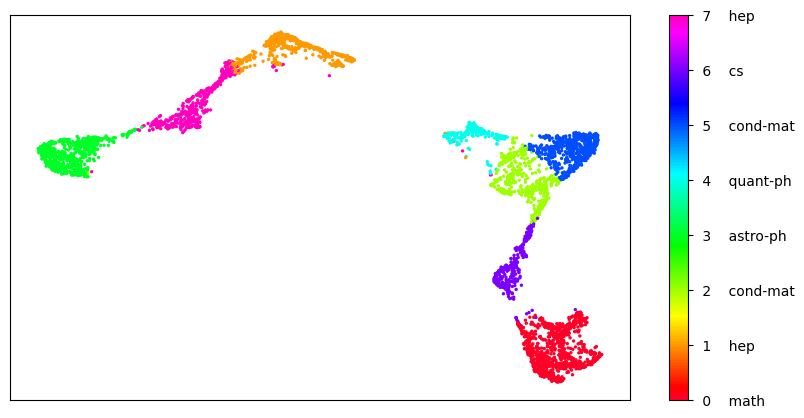

In [22]:
# Prepare 2D data for visualization
result = pd.DataFrame(umap_embeddings_2d, columns=['x', 'y'])
result['labels'] = cluster.labels_


plt.figure(figsize=(10, 5))
plt.scatter(result.x, result.y, c=result.labels, s=2, cmap='gist_rainbow');
colorbar = plt.colorbar();
plt.xticks([]); plt.yticks([]); plt.xlabel(''); plt.ylabel('');

# Set custom colorbar labels
categories = []
test_data['labels'] = list(result['labels'])
for index, label in enumerate(sorted(test_data['labels'].unique())):
    x = test_data[test_data['labels'] == label]['category'].value_counts().nlargest(1)
    categories.append(str(index).rjust(2) + "    " + x.index[0])
colorbar.set_ticklabels(categories)

plt.savefig('2d-clusters.png')

In [23]:
test_data['clustering_labels'] = list(result['labels'])

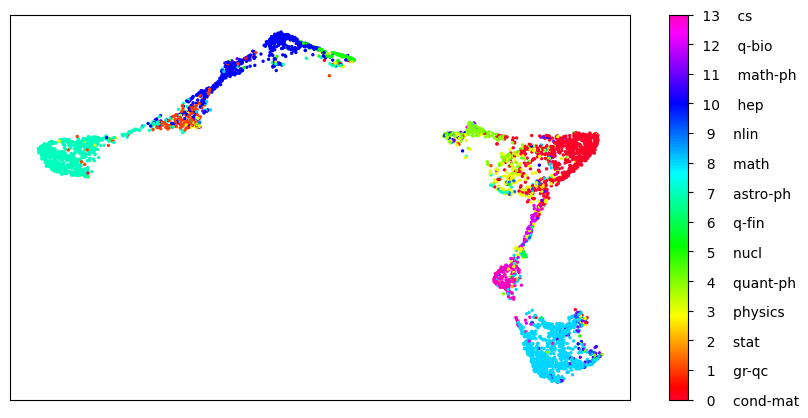

In [24]:
# Prepare 2D data for visualization
result = pd.DataFrame(umap_embeddings_2d, columns=['x', 'y'])

category_to_num = {category: number for number, category in enumerate(set(test_data['category']))}
mapped_category = [category_to_num[category] for category in test_data['category']]
result['labels'] = mapped_category


plt.figure(figsize=(10, 5))
# plt.scatter(outliers.x, outliers.y, color='#959595', s=5);
plt.scatter(result.x, result.y, c=result.labels, s=2, cmap='gist_rainbow');
colorbar = plt.colorbar();
plt.xticks([]); plt.yticks([]); plt.xlabel(''); plt.ylabel('');

# Set custom colorbar labels
colorbar.set_ticks(list(range(len(result['labels'].unique()))))
categories = []
test_data['labels'] = list(result['labels'])
for index, label in enumerate(sorted(test_data['labels'].unique())):
    x = test_data[test_data['labels'] == label]['category'].value_counts().nlargest(1)
    categories.append(str(index).rjust(3) + "    " + x.index[0])
colorbar.set_ticklabels(categories)

plt.savefig('2d-categories.png')

In [25]:
# # Prepare 3D data for visualization
# result = pd.DataFrame(umap_embeddings_3d, columns=['x', 'y', 'z'])
# result['labels'] = cluster.labels_

# ax = plt.axes(projection='3d')
# ax.grid()
# ax.scatter(result.x, result.y, result.z, c=result.labels, s=2, cmap='gist_rainbow');

# mappable = plt.cm.ScalarMappable(cmap='gist_rainbow')
# mappable.set_array(clustered.labels)
# colorbar = plt.colorbar(mappable, ax=ax, pad=0.05, shrink=0.8)  # Adjust the pad as needed
# ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]); # Remove tick text

In [26]:
# # Prepare data for visualization
# result = pd.DataFrame(umap_embeddings_3d, columns=['x', 'y', 'z'])

# category_to_num = {category: number for number, category in enumerate(set(test_data['category']))}
# mapped_category = [category_to_num[category] for category in test_data['category']]
# result['labels'] = mapped_category


# ax = plt.axes(projection='3d')
# ax.grid()
# ax.scatter(result.x, result.y, result.z, c=result.labels, s=2, cmap='gist_rainbow');

# mappable = plt.cm.ScalarMappable(cmap='gist_rainbow')
# mappable.set_array(clustered.labels)
# colorbar = plt.colorbar(mappable, ax=ax, pad=0.05, shrink=0.8)  # Adjust the pad as needed
# ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);

## Measure clustering performance


In [27]:
print("Unique categories: ", len(test_data['category'].unique()))
test_data['category'].value_counts()

Unique categories:  14


category
math        973
astro-ph    885
cond-mat    870
hep         779
physics     334
quant-ph    282
cs          248
gr-qc       177
nucl        139
math-ph      98
q-bio        68
nlin         64
q-fin        21
stat         12
Name: count, dtype: int64

In [28]:
for label in sorted(test_data['clustering_labels'].unique()):
    print(f"label={label}, size={len(test_data[test_data['clustering_labels'] == label])}")
    print("-------------")
    print(test_data[test_data['clustering_labels'] == label]['category'].value_counts().nlargest(3))
    print('\n')
print()


label=0, size=1057
-------------
category
math       911
math-ph     58
nlin        23
Name: count, dtype: int64


label=1, size=647
-------------
category
hep        453
nucl       126
physics     31
Name: count, dtype: int64


label=2, size=480
-------------
category
cond-mat    181
physics     174
quant-ph     45
Name: count, dtype: int64


label=3, size=814
-------------
category
astro-ph    792
gr-qc        11
physics       7
Name: count, dtype: int64


label=4, size=289
-------------
category
quant-ph    204
physics      28
cond-mat     23
Name: count, dtype: int64


label=5, size=699
-------------
category
cond-mat    635
physics      23
quant-ph     14
Name: count, dtype: int64


label=6, size=394
-------------
category
cs         229
q-bio       38
physics     36
Name: count, dtype: int64


label=7, size=570
-------------
category
hep         292
gr-qc       154
astro-ph     63
Name: count, dtype: int64



